In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

In [7]:
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_2)

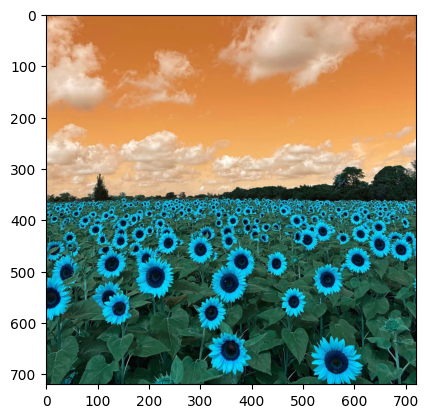

In [8]:
plt.imshow(im)

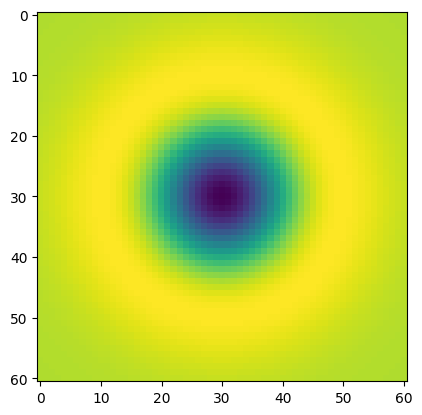

In [9]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 10
hw = 3*sigma
X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))

plt.imshow(log)

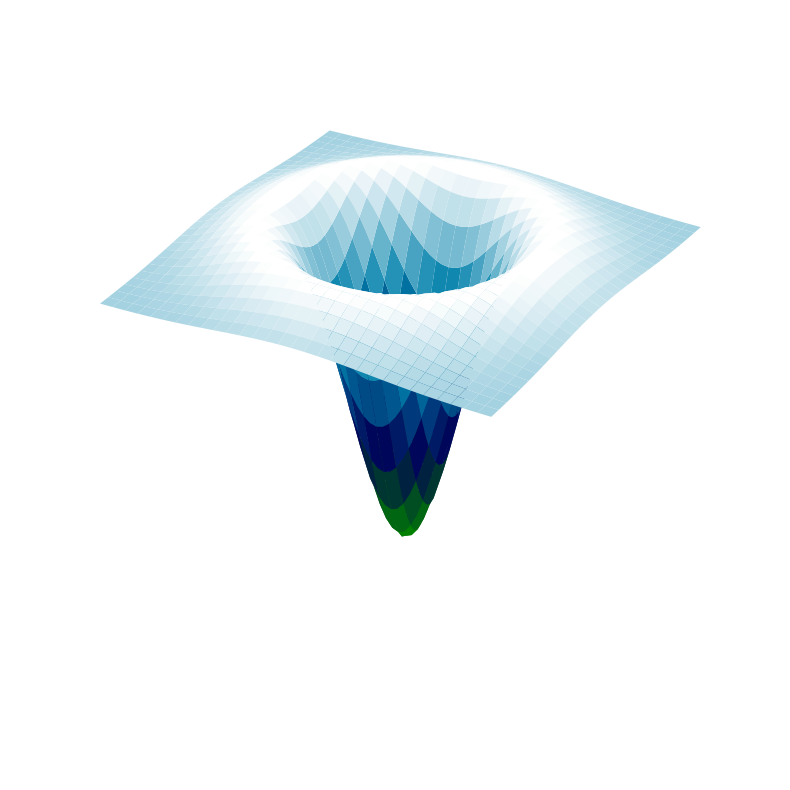

In [10]:
# This is not required
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, log, cmap=cm.ocean, linewidth = 0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.axis('off')
plt.show()

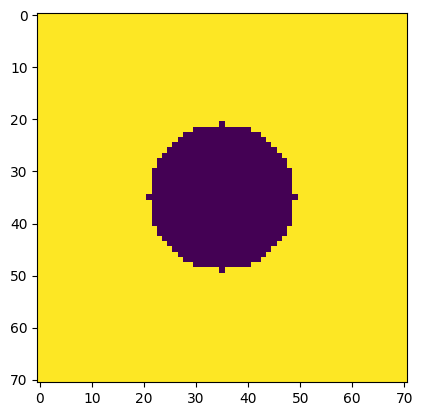

In [11]:
# Generating the circle
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

w, h = 71, 71
hw, hh = w//2, h//2
f = np.ones((h,w), dtype=np.float32)*255
X, Y = np.meshgrid(np.arange(-hh, hh + 1, 1), np.arange(-hw, hw + 1, 1))
r = w//5 # 14
f *= X**2 + Y**2 >  r**2
plt.imshow(f)

ValueError: could not broadcast input array from shape (1555200,1) into shape (71,71)

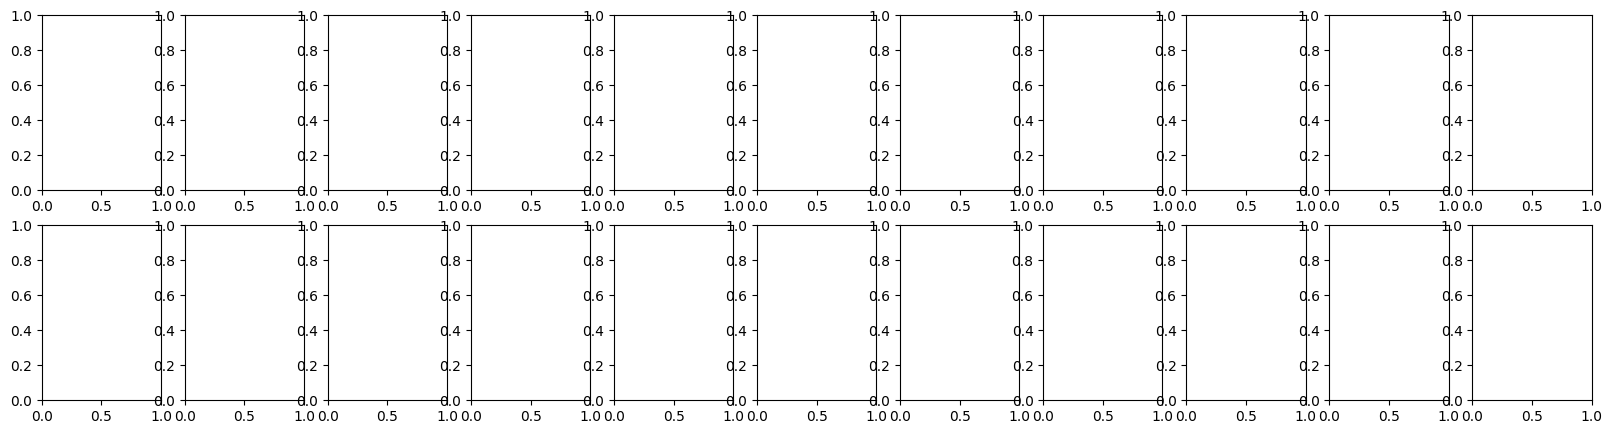

In [13]:
s = 11
fig, ax = plt.subplots(2, s, figsize=(20,5))
scale_space = np.empty((h, w, s), dtype=np.float32)
sigmas = np.arange(5, 16, 1)
for i, sigma in enumerate(sigmas):
    log_hw = 3*np.max(sigmas)
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1, 1), np.arange(-log_hw, log_hw + 1, 1))
    log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
    f_log = cv.filter2D(im, -1, log)
    scale_space[:, :, i] = f_log
    ax[0, i].imshow(log)
    ax[0, i].axis('off')
    ax[0, i].set_title(r'$\sigma = {}$'.format(sigma))    
    ax[1, i].imshow(f_log)
    ax[1, i].axis('off')   

indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
print(indices) # r = \sqrt{2}*sigma 
print(sigmas[indices[2]])

In [1]:
import cv2
import numpy as np

# Load the sunflower field image
im = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Define the range of sigma values
min_sigma = 10
max_sigma = 30
num_sigma = 10

# Perform blob detection using LoG and scale-space extrema detection
circles = cv2.HoughCircles(
    gray,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=0,
    maxRadius=0
)

print(circles)
# Draw circles on the original image
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for circle in circles[0, :]:
#         center = (circle[0], circle[1])
#         radius = circle[2]
#         cv2.circle(im, center, radius, (0, 255, 0), 2)

#     # Display the image with circles
#     cv2.imshow("Circles Detected", im)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

#     # Report the parameters of the largest circle
#     largest_circle = circles[0, 0]
#     largest_radius = largest_circle[2]
#     print("Parameters of the largest circle:")
#     print("Center:", (largest_circle[0], largest_circle[1]))
#     print("Radius:", largest_radius)

#     # Report the range of sigma values used
#     print("Range of σ values used:")
#     print("Min σ:", min_sigma)
#     print("Max σ:", max_sigma)
# else:
#     print("No circles detected.")


In [1]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("the_berry_farms_sunflower_field.jpeg",0) #gray scale conversion
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [2]:
def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [3]:
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y #sigma 
        filter_log = LoG(sigma_1) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) # squaring the response
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np
log_image_np = LoG_convolve(img)
#print(log_image_np.shape)

In [4]:
def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #9*3*3 slice
            result = np.amax(slice_img) #finding maximum
            if result >= 0.03: #threshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

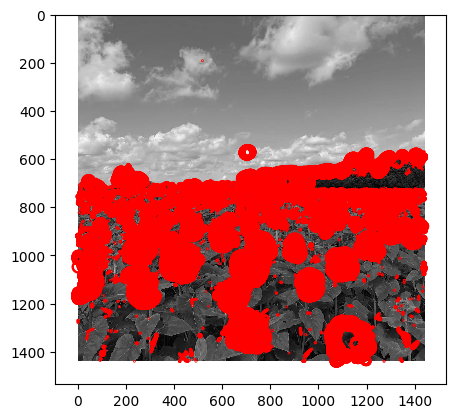

In [6]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

In [15]:
#provided in scipy doucumentaion
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)
        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)
        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1
        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))
    
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])

In [16]:
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

In [1]:
import cv2
import numpy as np
from scipy import ndimage as ndi

def blob_detection(image, min_sigma=1, max_sigma=10, num_sigma=10, threshold=0.05):
  """Detects blobs in an image using the Laplacian of Gaussians (LoG) method.

  Args:
    image: A 2D numpy array representing the image.
    min_sigma: The minimum sigma value to use for the LoG filter.
    max_sigma: The maximum sigma value to use for the LoG filter.
    num_sigma: The number of sigma values to use for the LoG filter.
    threshold: The threshold value to use for detecting blobs.

  Returns:
    A list of tuples, where each tuple contains the (x, y) coordinates and radius of a blob.
  """

  # Compute the LoG filter for each sigma value.
  log_filters = []
  for sigma in np.linspace(min_sigma, max_sigma, num_sigma):
    log_filters.append(ndi.gaussian_laplace(image, sigma=sigma))

  # Find the local maxima of the LoG filters.
  local_maxima = []
  for log_filter in log_filters:
    local_maxima.append(ndi.maximum_filter(log_filter, size=3))

  # Threshold the local maxima to find the blobs.
  blobs = []
  for local_maximum in local_maxima:
    blobs.extend([(x, y, ndi.distance(local_maximum, local_maximum.max())) for x, y in zip(*np.where(local_maximum > threshold))])

  return blobs

# Example usage:

image = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)

# Detect blobs in the image.
blobs = blob_detection(image, min_sigma=1, max_sigma=10, num_sigma=10, threshold=0.05)

# Draw circles around the blobs.
for blob in blobs:
  cv2.circle(image, (blob[0], blob[1]), int(blob[2]), (0, 0, 255), 2)

# Display the image.
cv2.imshow('Image', image)
cv2.waitKey(0)


ValueError: too many values to unpack (expected 2)